<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic = '/Users/ayano/Desktop/Data Science & AI/csv/titanic_train.csv'

In [3]:
df=pd.read_csv(titanic,  index_col="PassengerId")

In [4]:
# DataFrameの先頭を表示
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values.

In [5]:
# ANSWER
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# 特徴の選択
selected_features = ["Age", "Sex", "Parch", "Pclass", "Survived"]

In [8]:
# 選択した特徴のデータを抽出
df = df[selected_features]

In [9]:
# 欠損値の確認
df.isnull().sum()

Age         177
Sex           0
Parch         0
Pclass        0
Survived      0
dtype: int64

In [10]:
# 欠損値の処理
df["Age"].fillna(df["Age"].median(), inplace=True)

In [11]:
df.shape

(891, 5)

In [12]:
df.dtypes

Age         float64
Sex          object
Parch         int64
Pclass        int64
Survived      int64
dtype: object

In [13]:
# "Sex" 列の文字列を数値に変換 (例: 男性を0、女性を1とする)
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [14]:
#ランダムフォレスト

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ターゲットと特徴の選択
target = "Survived"
features = ["Pclass", "Parch"]

# ターゲットと特徴の抽出
X = df[features]
y = df[target]

# データの分割 (トレーニングデータとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレスト分類モデルのインスタンス化
model = RandomForestClassifier(random_state=42)

# モデルの訓練
model.fit(X_train, y_train)

# モデルの予測
y_pred = model.predict(X_test)

# モデルの評価 (正確性)
accuracy = accuracy_score(y_test, y_pred)
print("モデルの正確性(accuracy):", accuracy)

モデルの正確性(accuracy): 0.7206703910614525


In [15]:
#ロジスティック回帰

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# ターゲットと特徴の選択
target = "Survived"
features = ["Pclass", "Parch"]

# ターゲットと特徴の抽出
X = df[features]
y = df[target]

# データの分割 (トレーニングデータとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ロジスティック回帰モデルのインスタンス化
model = LogisticRegression()

# モデルの訓練
model.fit(X_train, y_train)

# モデルの予測
y_pred = model.predict(X_test)

# モデルの評価 (正確性)
accuracy = accuracy_score(y_test, y_pred)
print("ロジスティック回帰モデルの正確性(accuracy):", accuracy)


ロジスティック回帰モデルの正確性(accuracy): 0.7150837988826816


#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [16]:
# ANSWER

#ロジスティック回帰

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# ターゲットと特徴の選択
target = "Survived"
features = ["Pclass", "Parch"]

# ターゲットと特徴の抽出
X = df[features]
y = df[target]

# データの分割 (トレーニングデータとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ロジスティック回帰モデルのインスタンス化
model = LogisticRegression()

# モデルの訓練
model.fit(X_train, y_train)

# モデルの予測
y_pred = model.predict(X_test)

# モデルの評価 (正確性)
accuracy = accuracy_score(y_test, y_pred)
print("ロジスティック回帰モデルの正確性(accuracy):", accuracy)

ロジスティック回帰モデルの正確性(accuracy): 0.6536312849162011


#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [17]:
# ANSWER
# Create Model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [18]:
# ANSWER
# Fit Model

model.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [19]:
# ANSWER

# ロジスティック回帰モデルのインスタンス化と訓練
model = LogisticRegression()
model.fit(X_train, y_train)

# 係数の取得
coefficients = model.coef_[0]

The computed intercept (`intercept_`) is the 1st element of another array:

In [20]:
# ANSWER

# ロジスティック回帰モデルのインスタンス化と訓練
model = LogisticRegression()
model.fit(X_train, y_train)

# 切片の取得
intercept = model.intercept_[0]

We can create tuples of the predictor names and coefficients like this:

In [21]:
# ANSWER
print(set(zip(feature_cols, model.coef_[0])))

NameError: name 'feature_cols' is not defined

If we want formatted output, here is a neat way to list the coefficients by predictor:

In [22]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.908242
Parch       +0.334322


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [23]:
# ANSWER

# モデルによるトレーニングデータの予測
y_train_pred = model.predict(X_train)

# 正確性（accuracy_score）の計算
train_accuracy = accuracy_score(y_train, y_train_pred)

print("トレーニングデータの正確性:", train_accuracy)

トレーニングデータの正確性: 0.6924157303370787


What is the  `accuracy_score` for the test data?

In [24]:
# ANSWER

# モデルによるテストデータの予測
y_test_pred = model.predict(X_test)

# テストデータの正確性を計算
test_accuracy = accuracy_score(y_test, y_test_pred)

print("テストデータの正確性:", test_accuracy)

テストデータの正確性: 0.6536312849162011


What can we say about this result?

ANSWER
- ...
- ...

In [25]:
#This means that the model exhibits relatively high accuracy on the training data but slightly lower accuracy on the test data.

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [26]:
# ANSWER

# 年齢の欠損値を全体の平均年齢で置き換える
mean_age = df['Age'].mean()
df['Age'].fillna(mean_age, inplace=True)

# ターゲットと特徴の選択
target = "Survived"
features = ["Pclass", "Parch", "Age"]  # 年齢を追加

# ターゲットと特徴の抽出
X = df[features]
y = df[target]

In [27]:
# Build Model
# データの分割 (トレーニングデータとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ロジスティック回帰モデルのインスタンス化
model = LogisticRegression()


# Fit Model
# モデルの訓練
model.fit(X_train, y_train)


# モデルによるトレーニングデータの予測
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)


# Score

# 正確性（accuracy_score）の計算
train_accuracy = accuracy_score(y_train, y_train_pred)
print("トレーニングデータの正確性(accuracy_training_data):", train_accuracy)

# モデルの評価 (正確性)
accuracy = accuracy_score(y_test, y_pred)
print("ロジスティック回帰モデルの正確性(accuracy):", accuracy)

トレーニングデータの正確性(accuracy_training_data): 0.726123595505618
ロジスティック回帰モデルの正確性(accuracy): 0.6703910614525139


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

In [28]:
#It is possible that age has a low correlation with the other features.

Let's see where the model is going wrong by showing the Confusion Matrix:

In [29]:
# ANSWER

from sklearn.linear_model import LogisticRegression
from sklearn import metrics  # metricsモジュールのインポート

# ロジスティック回帰モデルのインスタンス化
logreg = LogisticRegression()

# モデルの訓練
logreg.fit(X_train, y_train)

# モデルの訓練が完了したので、予測を行うことができる
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))


[[89 17]
 [42 31]]


Nb. Here is how `confusion_matrix` arranges its output:

In [30]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

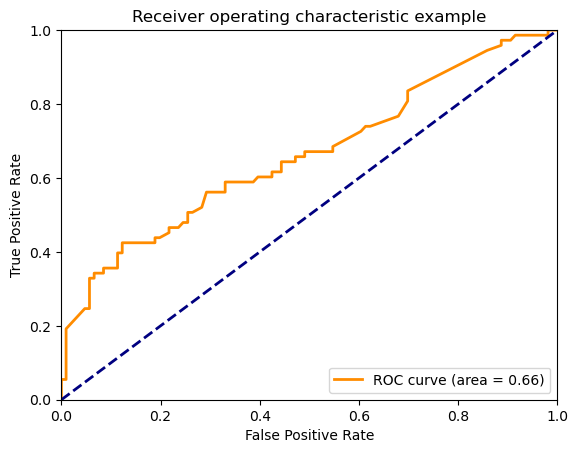

In [31]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [32]:
titanic_with_dummies = pd.get_dummies(data=titanic, columns=['Sex', 'Embarked', 'Pclass'], prefix=['Sex', 'Embarked', 'Pclass'])
titanic_with_dummies.head()

,"['Sex', 'Embarked', 'Pclass']_/Users/ayano/Desktop/Data Science & AI/csv/titanic_train.csv"
0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [33]:
titanic_with_dummies['Age'] = titanic_with_dummies.groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

KeyError: 'Parch'

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [34]:
# ANSWER
# Set Feature Both Numerical, Categorical

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ターゲットと特徴の選択
target = "Survived"
features = titanic_with_dummies['Age']

# ターゲットと特徴の抽出
X = titanic_with_dummies[features]
y = titanic_with_dummies[target]

# データの分割 (トレーニングデータとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ロジスティック回帰モデルのインスタンス化
logreg = LogisticRegression()

# モデルの訓練
logreg.fit(X_train, y_train)

# モデルの予測
y_pred = logreg.predict(X_test)

# モデルの評価 (正確性)
accuracy = accuracy_score(y_test, y_pred)
print("モデルの正確性:", accuracy)


KeyError: 'Age'

Plot the ROC curve for the new model:

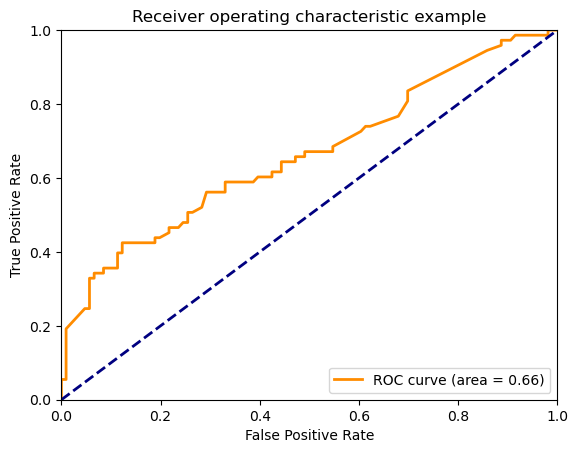

In [35]:
# ANSWER

# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [ ]:
# ANSWER

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



